In [1]:
import shap
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import lime
import lime.lime_tabular
from xgboost import XGBClassifier
from sklearn.inspection import PartialDependenceDisplay
from sklearn import tree

/home/stas/Documents/University/Masters/semester 3/ILM/TeachingCase/ilm_p3_12/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Data loading and cleaning

In [26]:
# load the data
data = pd.read_csv("../02_Myocardial_infarction_complications_Database.csv")

In [27]:
# remove the columns corresponding to other complications that we do not want to predict
data = data.drop('KFK_BLOOD', axis=1)
data = data.drop('IBS_NASL', axis=1)
data = data.drop('LET_IS', axis=1)
data = data.drop('P_IM_STEN', axis=1)
data = data.drop('REC_IM', axis=1)
data = data.drop('DRESSLER', axis=1)
data = data.drop('RAZRIV', axis=1)
data = data.drop('OTEK_LANC', axis=1)
data = data.drop('A_V_BLOK', axis=1)
data = data.drop('FIBR_JELUD', axis=1)
data = data.drop('JELUD_TAH', axis=1)
data = data.drop('PREDS_TAH', axis=1)
data = data.drop('FIBR_PREDS', axis=1)
data = data.drop('ID', axis=1)

data = data.fillna(0)

### Model training

Separate features and target variable

In [28]:
X = data.drop('ZSN', axis=1)
one_hot_X = pd.get_dummies(X)
y = data.ZSN

In [29]:
X_train, X_test, y_train, y_test = train_test_split(one_hot_X, y, test_size=0.2)
model = XGBClassifier()
model.fit(X_train.values, y_train.values)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

### LIME explainer

In the following cell we create the lime explainer, which helps us understand the motive behind model predictions, and we choose two specific case where the model is highly confident in predicting either outcome.

In [30]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    X_train.values, 
    feature_names=X_train.columns.values.tolist(),
    class_names=[0,1], verbose=True, 
    mode='classification'
)
#explainer = lime.lime_tabular.LimeTabularExplainer(X_train, feature_names=X_train.columns.values.tolist(), class_names=['ZSN'], mode='classification', verbose=True)

# We set our confidence treshold at 80% 
j = 0
k = 0
thresh = 0.8

# We get the propability predictions for all test cases
preds = model.predict_proba(X_test)

# find an example where the prediction is 1:
for i in range(42):
    if (preds[i])[0]>thresh: # If probability of class 0 is >80%
        j = i
    if (preds[i])[1]>thresh: # If probability of class 1 is >80%
        k = i

print("prediction for instance", j, "in test data:", model.predict_proba(X_test)[j])
print("prediction for instance", k, "in test data:", model.predict_proba(X_test)[k])

prediction for instance 41 in test data: [0.9095135  0.09048656]
prediction for instance 7 in test data: [0.01295036 0.98704964]


In [67]:
# generate a LIME explanation for the first chosen instance:
exp = explainer.explain_instance(X_test.values[j], model.predict_proba, num_features=6)

feature_weights = exp.as_list()  # This gets all feature-weight pairs
for feature, weight in feature_weights:
    print(f"Feature: {feature:<30} Weight: {weight:>10.4f}")
exp.show_in_notebook(show_table=True)

Intercept 0.6001729351865112
Prediction_local [0.03956265]
Right: 0.09048656
Feature: ZSN_A <= 0.00                  Weight:    -0.3539
Feature: zab_leg_01 <= 0.00             Weight:    -0.0972
Feature: endocr_01 <= 0.00              Weight:    -0.0696
Feature: 100.00 < S_AD_ORIT <= 130.00   Weight:    -0.0397
Feature: ALT_BLOOD <= 0.15              Weight:    -0.0355
Feature: AGE > 70.00                    Weight:     0.0352


In [61]:
# generate a LIME explanation for the second chosen instance:
exp = explainer.explain_instance(X_test.values[k], model.predict_proba, num_features=6)

feature_weights = exp.as_list()  # This gets all feature-weight pairs
for feature, weight in feature_weights:
    print(f"Feature: {feature:<30} Weight: {weight:>10.4f}")
exp.show_in_notebook(show_table=True)

Intercept 0.18176302014094822
Prediction_local [0.57567081]
Right: 0.98704964
Feature: ZSN_A > 0.00                   Weight:     0.3743
Feature: endocr_01 <= 0.00              Weight:    -0.0791
Feature: NA_R_3_n > 0.00                Weight:     0.0650
Feature: zab_leg_01 > 0.00              Weight:     0.0563
Feature: ritm_ecg_p_02 <= 0.00          Weight:    -0.0549
Feature: 63.00 < AGE <= 70.00           Weight:     0.0323


### SHAP explainer

In this section we will analyze the predictions using the shapley values.

In [68]:
# Fits the explainer
explainer = shap.TreeExplainer(model)
# Calculates the SHAP values - may take some time
shap_values = explainer.shap_values(X_test)

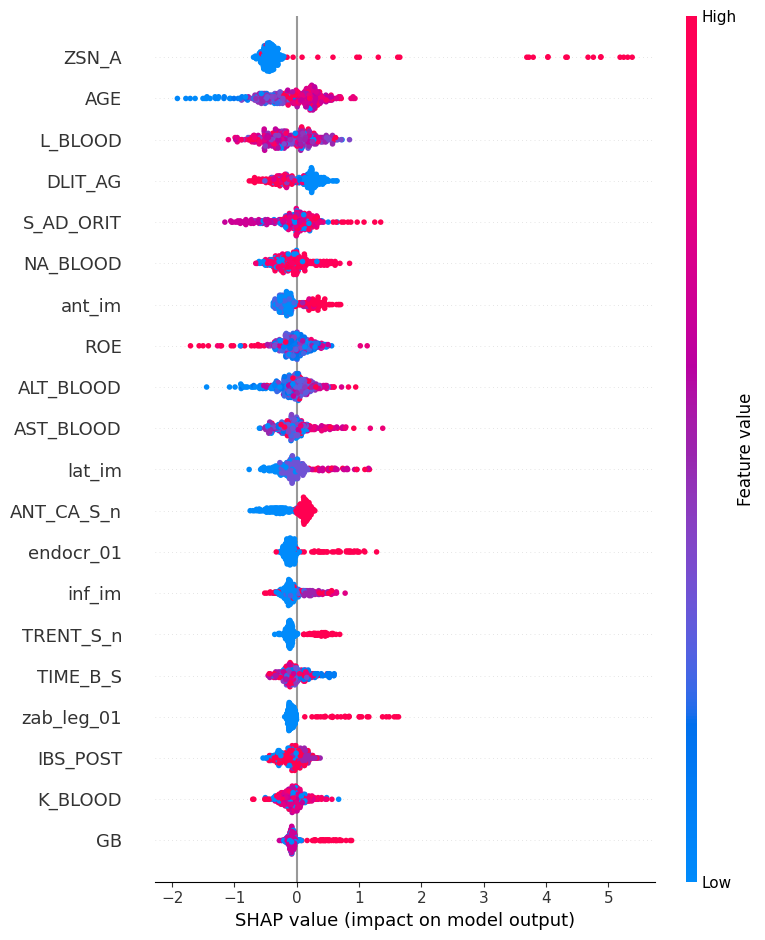

In [69]:
shap.summary_plot(shap_values, X_test)

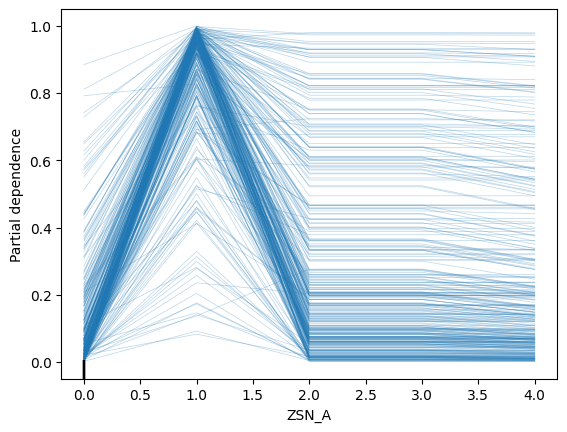

In [70]:
# select a feature, then create an individual conditional expectation plot 
# (using PDP plot, with kind = "individual")
features = [9]
PartialDependenceDisplay.from_estimator(model, X_test, features, kind='individual')

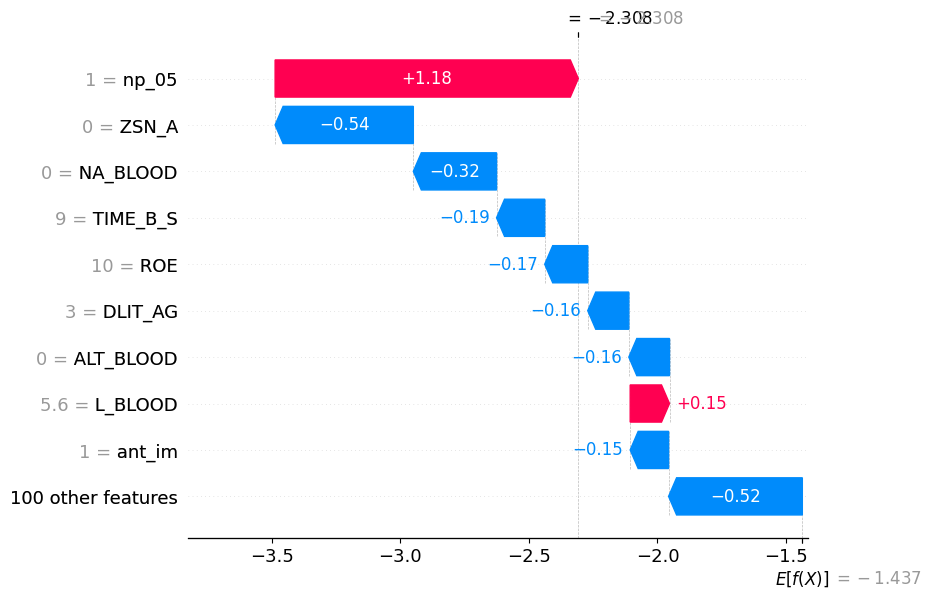

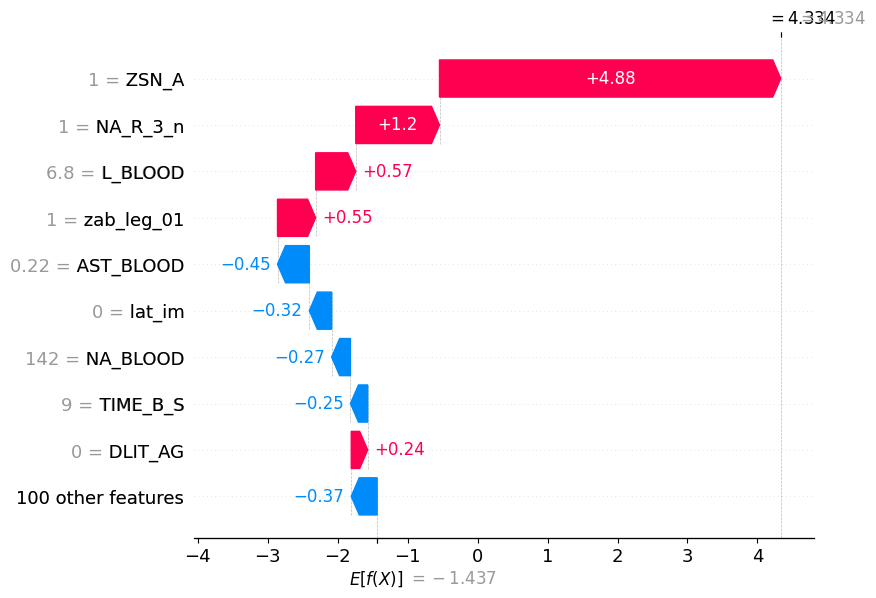

In [71]:
# let's produce SHAP waterfall plots for the two instances where the model is confident (see above):
expl = shap.TreeExplainer(model)
vals = expl(X_test)
shap.plots.waterfall(vals[j])
shap.plots.waterfall(vals[k])